# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][HW04] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом задании вам предстоит реализовать классический перцептрон, немного улчшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [1]:
from itertools import islice, cycle
from math import ceil
import numpy as np
import cv2
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
import copy
from typing import NoReturn, Tuple

In [2]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])  
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")
    
    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [3]:
class Perceptron:
    def __init__(self, iterations: int = 100):
        """
        Parameters
        ----------
        iterations : int
        Количество итераций обучения перцептрона.

        Attributes
        ----------
        w : np.ndarray
        Веса перцептрона размерности X.shape[1] + 1 (X --- данные для обучения), 
        w[0] должен соответстовать константе, 
        w[1:] - коэффициентам компонент элемента X.

        Notes
        -----
        Вы можете добавлять свои поля в класс.
        
        """

        self.w = None
        self._iterations = iterations
        self._labels = None

    def _prepare_x_y(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        self._labels, inds = np.unique(y, return_inverse=True)
        assert len(self._labels) == 2, f"You must provide 2 classes, but got {len(self._labels)}"
        y_signed = np.empty_like(y)
        y_signed[inds == 0] = -1
        y_signed[inds == 1] = 1

        x_biased = np.hstack((np.ones((X.shape[0], 1)), X))

        return x_biased, y_signed

    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Обучает простой перцептрон. 
        Для этого сначала инициализирует веса перцептрона,
        а затем обновляет их в течении iterations итераций.
        
        Parameters
        ----------
        X : np.ndarray
            Набор данных, на котором обучается перцептрон.
        y: np.ndarray
            Набор меток классов для данных.
        
        """
        X, y = self._prepare_x_y(X, y)
        self.w = np.zeros(X.shape[1], dtype=np.float32)

        example_iterator = cycle(zip(X, y))
        fixed_count = 0
        for x_i, y_i in example_iterator:
            if np.sign(x_i @ self.w) != y_i:
                self.w += y_i * x_i
                fixed_count += 1
            if fixed_count >= self._iterations:
                break

    def _pred_signs(self, X: np.ndarray) -> np.ndarray:
        if X.shape[1] != self.w.shape[0]:
            logits = X @ self.w[1:] + self.w[0]
        else:
            logits = X @ self.w
        return np.sign(logits)

    def _signs_to_labels(self, signs: np.ndarray) -> np.ndarray:
        y = np.empty_like(signs)
        y[signs == -1] = self._labels[0]
        y[signs == 1] = self._labels[1]
        return y

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказывает метки классов.
        
        Parameters
        ----------
        X : np.ndarray
            Набор данных, для которого необходимо вернуть метки классов.
        
        Return
        ------
        labels : np.ndarray
            Вектор индексов классов 
            (по одной метке для каждого элемента из X).
        
        """
        return self._signs_to_labels(self._pred_signs(X))

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

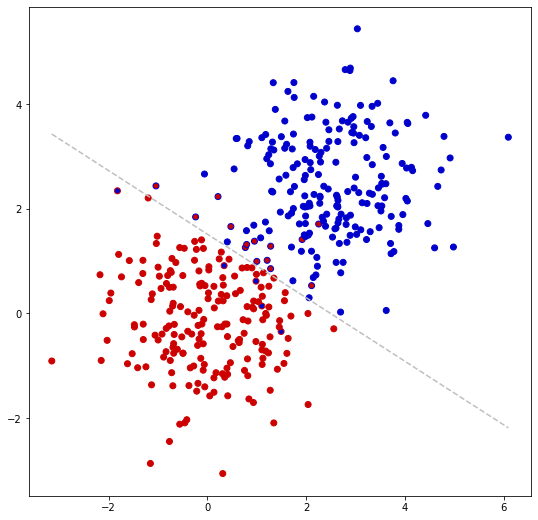

In [4]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

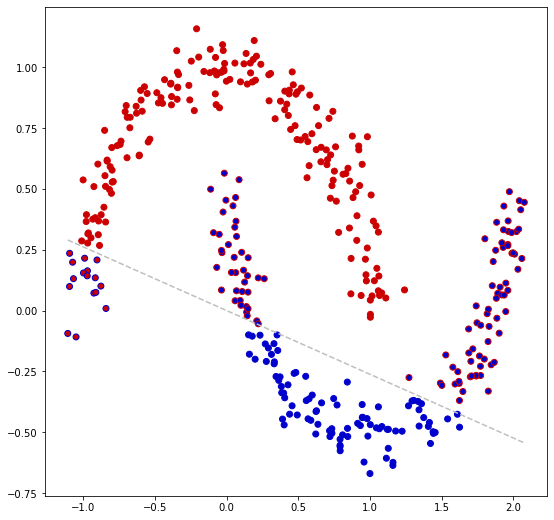

In [5]:
X, true_labels = make_moons(400, noise=0.075)
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [6]:
class PerceptronBest(Perceptron):
    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Обучает перцептрон.

        Для этого сначала инициализирует веса перцептрона, 
        а затем обновляет их в течении iterations итераций.

        При этом в конце обучения оставляет веса, 
        при которых значение accuracy было наибольшим.
        
        Parameters
        ----------
        X : np.ndarray
            Набор данных, на котором обучается перцептрон.
        y: np.ndarray
            Набор меток классов для данных.
        
        """
        X, y = self._prepare_x_y(X, y)

        self.w = np.zeros(X.shape[1], dtype=np.float32)
        best_w = None
        best_acc = float("-inf")

        for _ in range(self._iterations):
            y_pred = self._pred_signs(X)
            diffs = y_pred != y

            accuracy = np.mean(1 - diffs)
            if accuracy > best_acc:
                best_acc = accuracy
                best_w = self.w.copy()

            ind_to_fix = np.nonzero(diffs)[0]
            if ind_to_fix.size == 0:
                break
            ind_to_fix = ind_to_fix[0]
            self.w += y[ind_to_fix] * X[ind_to_fix]

        self.w = best_w

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

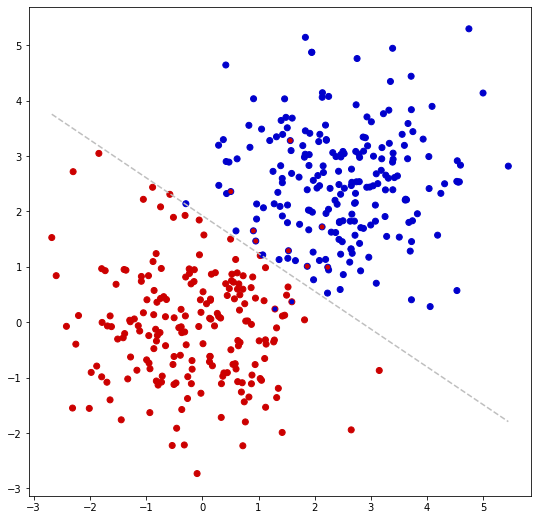

In [7]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

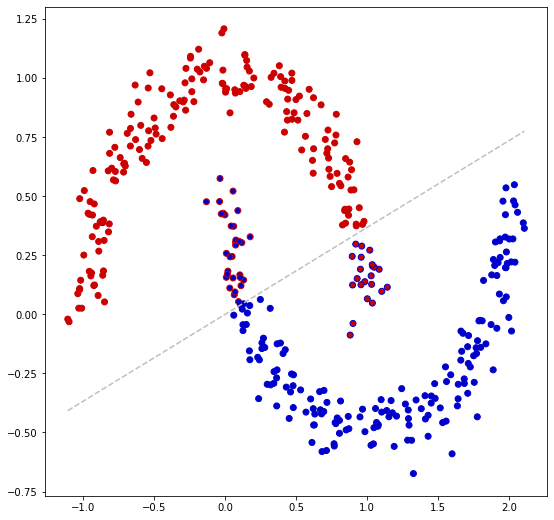

In [8]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 3 (1 балл)
Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [9]:
def transform_images(images: np.ndarray) -> np.ndarray:
    """
    Переводит каждое изображение в вектор из двух элементов.
        
    Parameters
    ----------
    images : np.ndarray
        Трехмерная матрица с черное-белыми изображениями.
        Её размерность: (n_images, image_height, image_width).

    Return
    ------
    np.ndarray
        Двумерная матрица с преобразованными изображениями.
        Её размерность: (n_images, 2).
    """
    def get_mean(images: np.ndarray) -> np.ndarray:
        return images.reshape(images.shape[0], -1).mean(axis=-1)

    def get_std(images: np.ndarray) -> np.ndarray:
        return images.reshape(images.shape[0], -1).std(axis=-1)

    def get_saturation(images: np.ndarray) -> np.ndarray:
        return images.reshape(images.shape[0], -1).mean(axis=-1)

    def get_width_height_ratio(images: np.ndarray) -> np.ndarray:
        threshd = images > 0.1
        features = np.empty(images.shape[0], dtype=np.float32)
        for i in range(images.shape[0]):
            ys, xs = np.nonzero(threshd[i])
            width = (xs.max() - xs.min()).astype(np.float32)
            height = (ys.max() - ys.min()).astype(np.float32)
            features[i] = width / height
        return features

    def get_vert_sym(images: np.ndarray) -> np.ndarray:
        """Норма разницы левой половины и правой половины (отзеркаленной).
        Вертикальная симметрия в каком-то смысле"""
        med_ind = images.shape[2] // 2
        diff = images[:, :, :med_ind] - images[:, :, :med_ind-1:-1]
        return np.linalg.norm(diff.reshape(images.shape[0], -1), axis=-1)

    def get_hor_sym(images: np.ndarray) -> np.ndarray:
        """Норма разницы верхней половины и нижней половины (отзеркаленной).
        Горизонтальная симметрия в каком-то смысле"""
        med_ind = images.shape[1] // 2
        diff = images[:, :med_ind] - images[:, :med_ind-1:-1]
        return np.linalg.norm(diff.reshape(images.shape[0], -1), axis=-1)

    def get_inner_outer_mass_diff(images: np.ndarray) -> np.ndarray:
        center_mass = images[:, 2:6, 2:6].reshape(images.shape[0], -1).sum(axis=-1)
        outer_inds = [0, 1, 6, 7]
        outer_mass = images[:, outer_inds, outer_inds].reshape(images.shape[0], -1).sum(axis=-1)
        return center_mass - outer_mass

    def apply_kernel(images: np.ndarray, kernel: np.array) -> np.ndarray:
        out = np.empty(images.shape[0])
        for i, image in enumerate(images):
            out[i] = cv2.filter2D(image, -1, kernel).mean()
        return out

    def get_vert_kernel(images: np.ndarray) -> np.ndarray:
        kernel = np.array([
            [0, 1, 0],
            [0, 1, 0],
            [0, 1, 0]
        ]).T
        return apply_kernel(images, kernel)

    def get_hor_kernel(images: np.ndarray) -> np.ndarray:
        kernel = np.array([
            [0, 0, 0],
            [1, 1, 1],
            [0, 0, 0]
        ]).T
        return apply_kernel(images, kernel)

    def get_cross_kernel(images: np.ndarray) -> np.ndarray:
        kernel = np.array([
            [0, 1, 0],
            [1, 1, 1],
            [0, 1, 0]
        ])
        return apply_kernel(images, kernel)

    def get_diag_kernel(images: np.ndarray) -> np.ndarray:
        kernel = np.array([
            [0, 0, 1],
            [0, 1, 0],
            [1, 0, 0]
        ]).T
        return apply_kernel(images, kernel)

    def get_corner_kernel(images: np.ndarray) -> np.ndarray:
        kernel = np.array([
            [1, 1, 1],
            [1, 0, 0],
            [1, 0, 0]
        ])
        return apply_kernel(images, kernel)

    feature_1 = get_vert_sym(images)
    feature_2 = get_hor_sym(images)

    return np.hstack((feature_1.reshape(-1, 1), feature_2.reshape(-1, 1)))

def get_digits(y0=1, y1=5):
    data = datasets.load_digits()
    images, labels = data.images, data.target
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    X = transform_images(images)
    return X, labels

### Задание 4 (4 балла)
Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Оценка за это задание выставляется следующим образом:
1. 1 балл - что-то обучается, картинки рисуются
2. 2 балла - точность хотя бы одного из классификаторов на тестовой выборке больше 80%
3. 4 балла - точность хотя бы одного из классификаторов на тестовой выборке больше 90%

__Обратите внимание, что перцептрон детерминирован, а выборка должна разбиваться без перемешивания__

In [10]:
X, y = get_digits()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

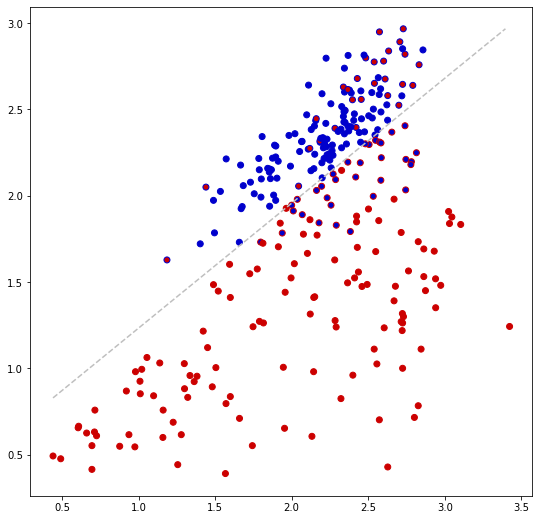

Accuracy: 0.8082191780821918


In [11]:
c = Perceptron(iterations=100000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

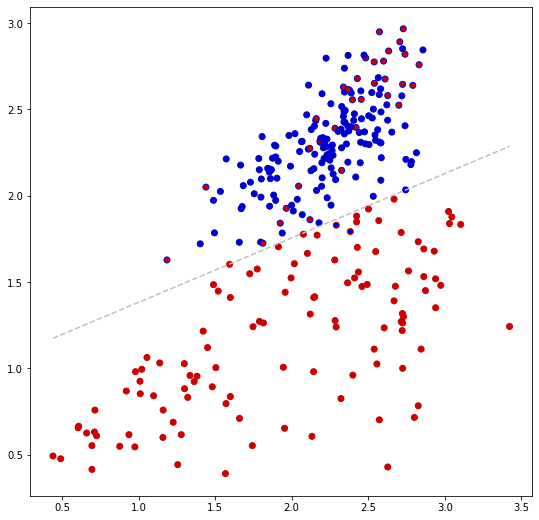

Accuracy: 0.9863013698630136


In [12]:
c = PerceptronBest(iterations=100000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [13]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = Perceptron(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.6903212187040728


In [14]:
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = PerceptronBest(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.7834801809333933
